In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('ggplot')

In [2]:
def ISLR2data(name):
    import io
    import zipfile
    import urllib
    url = ("https://www.statlearning.com/s/"
           "ALL-CSV-FILES-2nd-Edition-corrected.zip")
    zipdata = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, index_col=0)
                break
    return df

def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data


In [3]:
def semifact(n):
    res = 1
    for k in range(n,1,-2):
        res *=k
    return res

def var_zn(n):
    if n%2==0:
        return semifact(2*n-1) - semifact(n-1)**2
    return semifact(2*n-1)



In [4]:
# "%e" %(semifact(19)-semifact(9)**2)
# print(pd.DataFrame({('$X^{%d}$' % n): var_zn(n)**0.5  for n in range(1,11)}, 
#                    index=['std']).round(2).to_latex(escape=False))

In [5]:
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline

[ 0.11645184 -0.35136216  0.03668829  1.03883255 -1.56988223  0.93456256
 -0.20529086]
[-1.05134845e-04 -2.63067503e-05 -4.24816625e-06  1.33210368e-05
  3.20929019e-05  8.15990385e-05  1.10227297e-04]


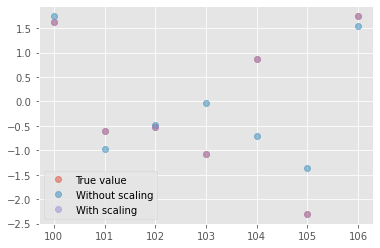

In [6]:
degree=6
yscale = 1 
np.random.seed(1)
lm=linear_model.LinearRegression()
x = np.linspace(100,100+degree,degree+1)
y = np.random.normal(size=degree+1)*yscale
X10 = preprocessing.PolynomialFeatures(degree=degree,include_bias=False).fit_transform(np.expand_dims(x,-1))
lm.fit(X10,y)
print(lm.predict(X10)-y)

lm1 = make_pipeline(preprocessing.StandardScaler(),
                    linear_model.LinearRegression())
lm1.fit(X10,y)
yhat  = lm.predict(X10)
yhat1 = lm1.predict(X10)
print(lm1.predict(X10)-y)

# err=pd.DataFrame([y-lm.predict(X10),y-lm1.predict(X10), y], 
#              columns=x,
#              index='wo scaling,with scaling,$y$'.split(",")).round(4)

# err.columns.name='$x$'
# err.index.name='$y-\hat y$'
# print(err.to_latex(escape=False))
plt.plot(x, y, 'o', alpha=0.5, label='True value')
plt.plot(x, yhat,'o', alpha=0.5, label='Without scaling')
plt.plot(x, yhat1, 'o', alpha=0.5, label='With scaling')
plt.legend()
plt.show()

In [7]:
import urllib
import pandas as pd
import numpy as np
import functools
import subprocess
import os
import json


def load_info(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return f.read().decode('utf-8')

def load_csv(name, read_csv_args):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return pd.read_csv(f, **read_csv_args)

def load_label(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return np.array([l.strip().decode('utf-8') for l in f.readlines()])
    
def to_array(d):
    if isinstance(d, dict):
        return {k: to_array(v) for k,v in d.items()}
    if isinstance(d, list):
        return np.array(d)
    return d

def load_rda(name):
    cmd = subprocess.run(
               ['Rscript', '--vanilla', 
                '-e' ,
                f'load(url("{ESL_datasets_url}{name}")); jsonlite::write_json(as.list(environment()), stdout())'],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
              )
    if cmd.returncode:
        print(cmd.stderr.decode('utf-8'))
        raise ValueError
    else:
        data = json.loads(cmd.stdout.decode('utf-8'))
        return to_array(data)


ESL_datasets_url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/'

ESL_datasets = {
        'prostate': {
          'meta': functools.partial(load_info, name='prostate.info.txt'), 
          'data': functools.partial(load_csv, name='prostate.data', 
                                    read_csv_args=dict(sep="\t", index_col=0))
        },
        'ozone': {
          'meta': functools.partial(load_info, name='ozone.info.txt'), 
          'data': functools.partial(load_csv, name='ozone.data', 
                                    read_csv_args=dict(sep="\t"))
        },
        'spam': {
          'meta': functools.partial(load_info, name='spam.info.txt'), 
          'data': functools.partial(load_csv, name='spam.data', 
                                    read_csv_args=dict(sep=' ', index_col=None, header=None))
        },
        'phoneme': {
          'meta': functools.partial(load_info, name='phoneme.info.txt'), 
          'data': functools.partial(load_csv, name='phoneme.data', 
                                    read_csv_args=dict(sep=',', index_col=0))
        },
        'nci_microarray': {
          'meta': functools.partial(load_info, name='nci.info.txt'), 
          'data': functools.partial(load_csv, name='nci.data.csv', 
                                    read_csv_args=dict(sep=',', index_col=0)),
          'label': functools.partial(load_label, name='nci.label'),
        },
        'sa_heart_disease': {
          'meta': functools.partial(load_info, name='SAheart.info.txt'), 
          'data': functools.partial(load_csv, name='SAheart.data', 
                                    read_csv_args=dict(sep=',', index_col='row.names'))
        },    
        'mixture':{
          'meta': functools.partial(load_info, name='mixture.example.info.txt'), 
          'data': functools.partial(load_rda, name='ESL.mixture.rda')
        },
    }   
    
class Dataset:
    def __init__(self, kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)
    def __repr__(self):
        return self.meta + '\n' + repr(self.data)
    def __str__(self):
        return str(self.data)
    
    
def load_ESL_dataset(name):
    return Dataset({k: v() for k, v in ESL_datasets[name].items()})


In [8]:
wage = ISLRdata('Wage')

In [9]:
cols = ['age','education','year']
grouped_wage = wage[['wage']+cols].groupby(cols)
RSS = grouped_wage.agg([lambda x: len(x)*((x**2).mean()-x.mean()**2)]).sum()
TSS = ((wage.wage-wage.wage.mean())**2).sum()
print(f" RSS:{float(RSS):.2f}, TSS:{TSS:.2f}, R^2:{1-float(RSS)/TSS:.3f}")
len(wage.age.unique())*len(wage.education.unique())*len(wage.year.unique()) - len(grouped_wage)

 RSS:2163252.83, TSS:5222085.77, R^2:0.586


883

In [10]:
from sklearn.metrics import make_scorer, mean_squared_error

def sigma_haty(model, X_train, y_train, X):
    X0 = model[:-1].transform(X_train)
    if model[-1].fit_intercept:
        X0 = np.concatenate([np.ones((X0.shape[0],1)),X0], axis=1)
    _, R = np.linalg.qr(X0)
    X0 = model[:-1].transform(X)
    if model[-1].fit_intercept:
        X0 = np.concatenate([np.ones((X0.shape[0],1)),X0], axis=1)
    sigma = make_scorer(mean_squared_error)(model, X_train, y_train)**0.5
    # print(sigma)
    return np.linalg.norm(np.linalg.solve(R.T,X0.T), axis=0)*sigma


In [11]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def conf_int_logistic(model, X_train, y_train, X):
    X0 = model[:-1].transform(X_train)
    X0 = np.concatenate([np.ones((X0.shape[0],1)),X0], axis=1)
    p = model.predict_proba(X_train)[:,1]
    w = (p*(1-p))**0.5
    _, R = np.linalg.qr(np.expand_dims(w,-1)*X0)
    X0 = model[:-1].transform(X)
    X0 = np.concatenate([np.ones((X0.shape[0],1)),X0], axis=1)
    d = 2*np.linalg.norm(np.linalg.solve(R.T,X0.T), axis=0)
    p = model.predict_proba(X)[:,1]
    eta = np.log(p/(1-p))
    return sigmoid(eta-d), sigmoid(eta+d)


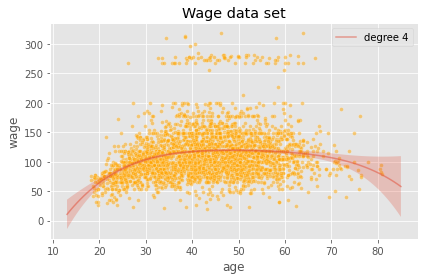

In [12]:
X = wage[['age']]
y = wage.wage
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 101)
x0_df = pd.DataFrame(dict(age=x0))

for d in range(4,5):
    poly = make_pipeline(preprocessing.PolynomialFeatures(degree=d,include_bias=False),
                      preprocessing.StandardScaler(),
                      linear_model.LinearRegression()).fit(X,y)
    haty = poly.predict(x0_df)
    sigma = sigma_haty(poly, X, y, x0_df)
    plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, alpha=0.25)
    plt.plot(x0,haty, alpha=0.5, label=f'degree {d}')

plt.legend()
plt.title('Wage data set')
# plt.savefig('plots/11-26-poly-wage.pdf')
plt.show()

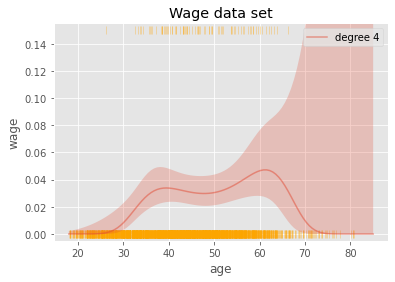

In [13]:
#print(X.shape,y.shape)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), 
                y=0.15*(y>250), 
                marker='|', s=50, color='orange', alpha=0.5)
x0 = np.linspace(X.age.min(), X.age.max()+5, 101)
x0_df = pd.DataFrame(dict(age=x0))

for d in range(4,5):
    poly = make_pipeline(preprocessing.PolynomialFeatures(degree=d,include_bias=False),
                      preprocessing.StandardScaler(),
                      linear_model.LogisticRegression(penalty='none',
                                                      solver='newton-cg')).fit(X,1*(y>250))
    haty = poly.predict_proba(x0_df)[:,1]
    plt.fill_between(x0, *conf_int_logistic(poly, X, y, x0_df), alpha=0.25)
    plt.plot(x0,haty, alpha=0.5, label=f'degree {d}')

plt.ylim(-0.005,0.155)
plt.legend()
plt.title('Wage data set')
plt.show()

In [14]:
heart = load_ESL_dataset('sa_heart_disease')

In [15]:
print(heart.meta)
print(heart.data.head())
heart.data.describe()

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

To read into R:
read.table("http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data",
	sep=",",head=T,row.names=1)

           sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
row.names    

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


<AxesSubplot:xlabel='obesity', ylabel='adiposity'>

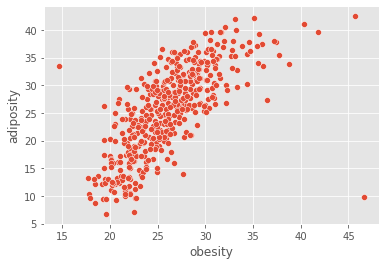

In [16]:
sns.scatterplot(x='obesity', y='adiposity', data=heart.data)

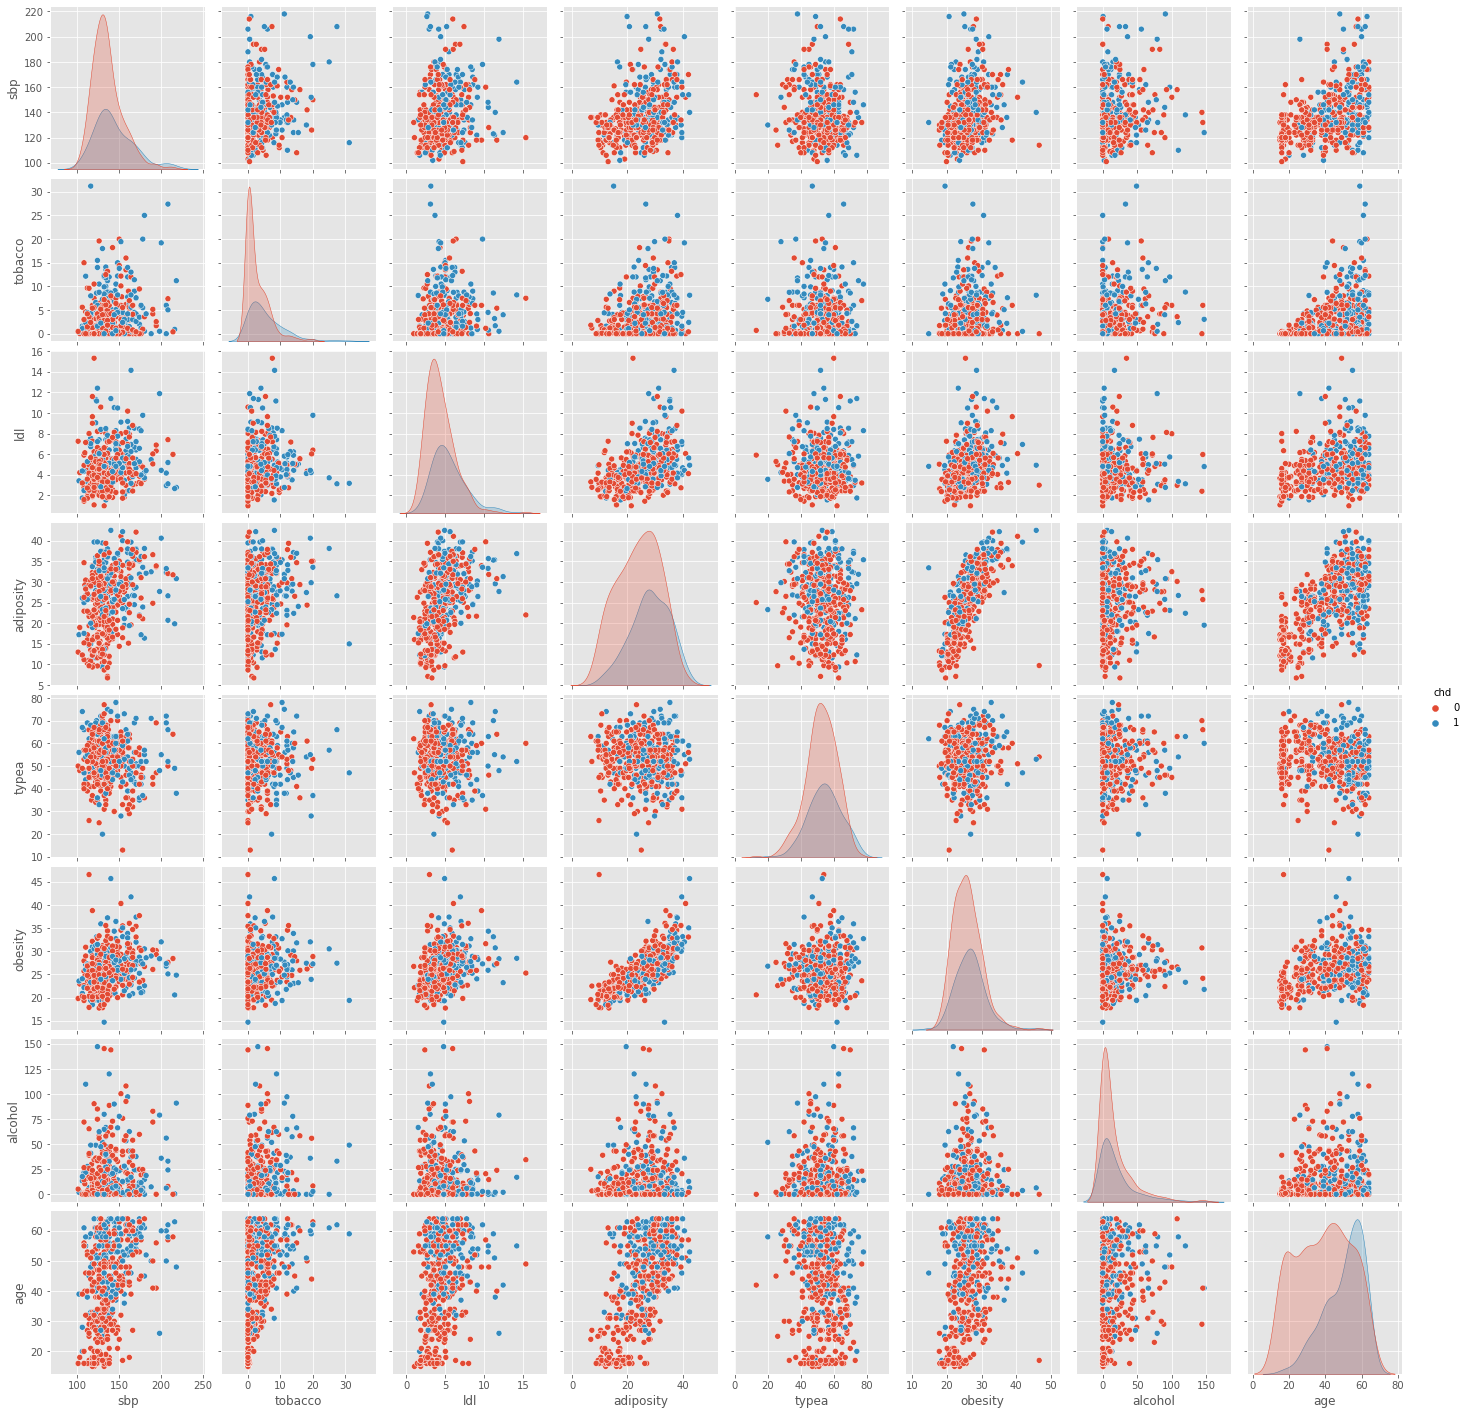

In [17]:
sns.pairplot(heart.data, hue='chd')

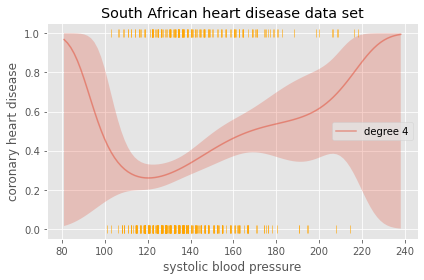

In [18]:
X, y = heart.data[['sbp']], heart.data.chd
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.sbp+np.random.uniform(size=len(X.sbp)), 
                y=y, s=50, marker='|', color='orange')
x0 = np.linspace(X.sbp.min()-20, X.sbp.max()+20, 101)
x0_df = pd.DataFrame(dict(sbp=x0))


for d in range(4,5):
    poly = make_pipeline(preprocessing.PolynomialFeatures(degree=d,include_bias=False),
                      preprocessing.StandardScaler(),
                      linear_model.LogisticRegression(penalty='none',
                                                      solver='newton-cg')).fit(X,y)
    haty = poly.predict_proba(x0_df)[:,1]
    plt.fill_between(x0, *conf_int_logistic(poly,X,y,x0_df),
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5, label=f'degree {d}')

plt.legend()
plt.xlabel('systolic blood pressure')
plt.ylabel('coronary heart disease')
plt.title('South African heart disease data set')
# plt.savefig('plots/11-26-poly-sa-heart.pdf')
plt.show()

In [19]:

import sklearn.decomposition as decomposition
import sklearn.compose as compose
import sklearn.feature_extraction as f_extraction
import sklearn.feature_selection as f_selection
import sklearn.preprocessing as preprocessing
import sklearn.kernel_ridge
import patsy

In [20]:
# preprocessing.KBinsDiscretizer?
None

In [21]:
def get_intervals(c_points):
    c0 = float(-np.inf)
    for c in c_points:
        c = float(c)
        yield c0,c
        c0=c
    yield c0,float(np.inf)

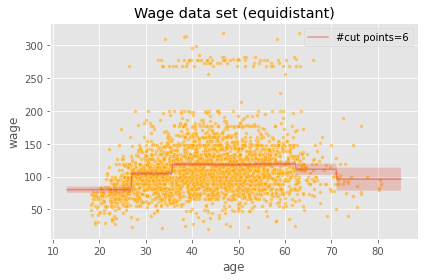

In [22]:
X = wage[['age']]
y = wage.wage
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
x0_df = pd.DataFrame(dict(age=x0))

for d in range(7,8):
    steps = make_pipeline(preprocessing.KBinsDiscretizer(n_bins=d, 
                                                         strategy='uniform',
                                                         encode='onehot-dense'),
                      linear_model.LinearRegression(fit_intercept=False)).fit(X,y)
    haty = steps.predict(x0_df)
    sigma = sigma_haty(steps, X, y, x0_df)
    plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, 
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5, label=f'#cut points={d-1}')
    
plt.legend()
plt.title('Wage data set (equidistant)')
# plt.savefig('plots/11-26-step-wage.pdf')
plt.show()

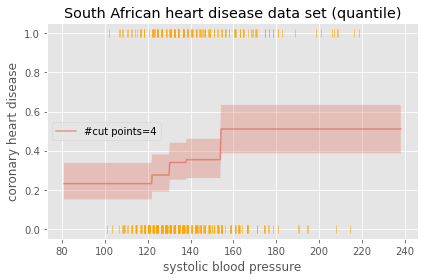

In [23]:
X, y = heart.data[['sbp']], heart.data.chd
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.sbp+np.random.uniform(size=len(X.sbp)), 
                y=y, s=50, marker='|', color='orange')
x0 = np.linspace(X.sbp.min()-20, X.sbp.max()+20, 501)
x0_df = pd.DataFrame(dict(sbp=x0))


for d in range(5,6):
    steps = make_pipeline(preprocessing.KBinsDiscretizer(n_bins=d, 
                                                         strategy='quantile', 
                                                         encode='onehot-dense'),
                        #PolynomialFeatures(degree=d,include_bias=False),
                        #preprocessing.StandardScaler(),
                        linear_model.LogisticRegression(penalty='none',
                                                        solver='newton-cg')).fit(X,y)
    haty = steps.predict_proba(x0_df)[:,1]
    #sigma = sigma_haty(poly, X, y, x0_df)
    plt.fill_between(x0, *conf_int_logistic(steps,X,y,x0_df), #haty-2*sigma,  haty+2*sigma, 
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5, label=f'#cut points={d-1}')

plt.legend()
plt.xlabel('systolic blood pressure')
plt.ylabel('coronary heart disease')
plt.title('South African heart disease data set (quantile)')
# plt.savefig('plots/11-26-step-sa-heart.pdf')
plt.show()

In [24]:
class PiecewisePoly:
    def __init__(self, poly_kwargs, kbin_kwargs):
        self.poly = preprocessing.PolynomialFeatures(**poly_kwargs)
        self.bin = preprocessing.KBinsDiscretizer(**kbin_kwargs)
    
    def fit(self, X, y=None, **kwargs):
        self.poly.fit(X, y)
        self.bin.fit(X, y)
        return self
    
    def transform(self, X, **kwargs):
        X0 = self.poly.transform(X)
        X1 = self.bin.transform(X)
        X = (np.expand_dims(X0, -1)*np.expand_dims(X1, -2))
        X = X.reshape(X0.shape[0], X0.shape[1]*X1.shape[1])
        return X
    
    def fit_transform(self, X, y=None, **kwargs):
        return self.fit(X, y, **kwargs).transform(X, **kwargs)

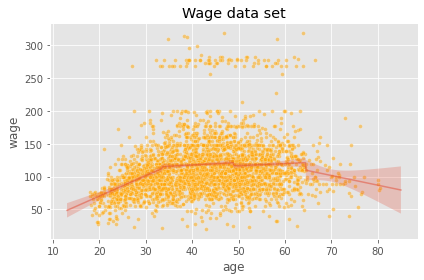

In [25]:
X = wage[['age']]
y = wage.wage
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5,color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
x0_df = pd.DataFrame(dict(age=x0))

for d in range(4,5):
    model = make_pipeline(PiecewisePoly(poly_kwargs=dict(degree=1),
                                        kbin_kwargs=dict(n_bins=d, 
                                             strategy='uniform',
                                             encode='onehot-dense'),
                                           ),
                          linear_model.LinearRegression(fit_intercept=False)).fit(X,y)
    haty = model.predict(x0_df)
    sigma = sigma_haty(model, X, y, x0_df)
    plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, alpha=0.25)
    plt.plot(x0,haty, alpha=0.5)

plt.title('Wage data set')
# plt.savefig('plots/11-26-pwlin-wage.pdf')
plt.show()

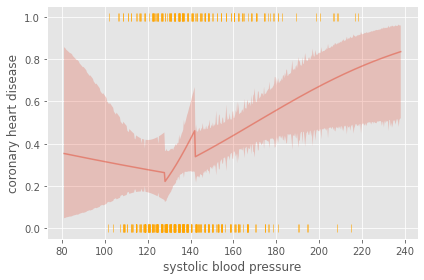

In [27]:
X, y = heart.data[['sbp']], heart.data.chd
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.sbp+np.random.uniform(size=len(X.sbp)), 
                y=y, s=50, marker='|', color='orange')
x0 = np.linspace(X.sbp.min()-20, X.sbp.max()+20, 501)
x0_df = pd.DataFrame(dict(sbp=x0))


for d in range(3,4):
    model = make_pipeline(PiecewisePoly(poly_kwargs=dict(degree=1),
                                        kbin_kwargs=dict(n_bins=d, 
                                             strategy='quantile',
                                             encode='onehot-dense'),
                                           ),
                        linear_model.LogisticRegression(penalty='none',
                                                        solver='newton-cg')).fit(X,y)
    haty = model.predict_proba(x0_df)[:,1]
    plt.fill_between(x0, *conf_int_logistic(model,X,y,x0_df),
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5) 

plt.xlabel('systolic blood pressure')
plt.ylabel('coronary heart disease')
# plt.title('South African heart disease data set (quantile)')
# plt.savefig('plots/11-26-pwlin-sa-heart.pdf')
plt.show()

[ 62.  75.  88. 101. 114. 127. 140. 153. 166. 179. 192. 205. 218. 231.
 244. 257.]


<AxesSubplot:>

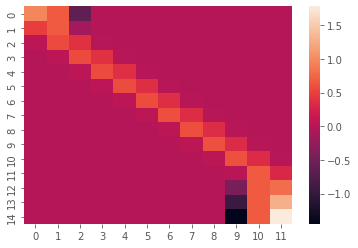

In [28]:
# print(np.percentile(X,[0,25,50,75,100]))
spl=preprocessing.SplineTransformer(degree=3, 
                                n_knots=10, #np.array([0,18,33.5,42,51,80,100]).reshape(-1,1),
                                extrapolation='linear').fit(X.values)
bspline = spl.bsplines_[0]
print(bspline.t)
sns.heatmap(spl.transform(np.linspace(80,260,15).reshape(-1,1)))

In [29]:
##preprocessing.SplineTransformer?

In [30]:
def get_knots(x,xmin,xmax,d,kind='uniform'):
    if kind=='uniform':
        knots = np.linspace(x.min(), x.max(), d+2)[1:-1]
    else:
        knots = np.linspace(0, 1, d+2)[1:-1]
        knots = np.quantile(x, knots)
    knots = np.concatenate([[xmin],knots,[xmax]])
    return knots


In [31]:
X = wage[['age']]
y = wage.wage
get_knots(X.age, x0.min(),x0.max(),7,'quantile')

array([ 81.   ,  28.   ,  33.75 ,  38.   ,  42.   ,  46.375,  51.   ,
        56.   , 238.   ])

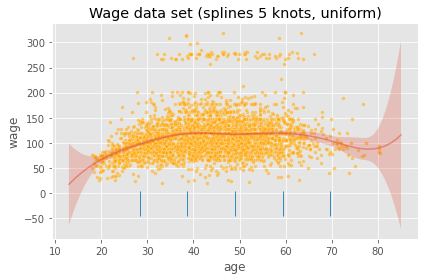

In [32]:
X = wage[['age']]
y = wage.wage

# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
x0_df = pd.DataFrame(dict(age=x0))


for d in range(5,6):
    knots = get_knots(X.age, x0.min(), x0.max(), d, 'uniform').reshape(-1,1)
    model = make_pipeline(preprocessing.SplineTransformer(#n_knots=d, 
                                                          degree=3,
                                                          knots=knots, #'uniform',
                                                          extrapolation='continue'),
                      linear_model.LinearRegression(fit_intercept=False)).fit(X,y)
    haty = model.predict(x0_df)
    sigma = sigma_haty(model, X, y, x0_df)
    plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, alpha=0.25)
    plt.plot(x0,haty, alpha=0.5) #, label=f'#cut points={d-1}')

kn = model[0].bsplines_[0].t[4:-4]
plt.plot(kn, np.zeros_like(kn)-20, '|', markersize=25)
plt.title(f'Wage data set (splines {d} knots, uniform)')
# plt.savefig('plots/11-26-splines-wage.pdf')
plt.show()

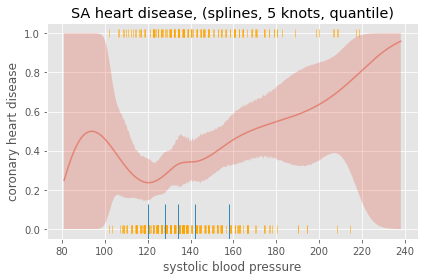

In [33]:
X, y = heart.data[['sbp']], heart.data.chd
# print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.sbp+np.random.uniform(size=len(X.sbp)), 
                y=y, s=50, marker='|', color='orange')
x0 = np.linspace(X.sbp.min()-20, X.sbp.max()+20, 501)
x0_df = pd.DataFrame(dict(sbp=x0))


for d in range(5,6):
    knots = get_knots(X.sbp, x0.min(), x0.max(), d, 'quantile').reshape(-1,1)
    model = make_pipeline(preprocessing.SplineTransformer(#n_knots=d, 
                                                          degree=3,
                                                          knots=knots, #'quantile',
                                                          extrapolation='continue'),
                          linear_model.LogisticRegression(penalty='none',
                                                          solver='newton-cg')).fit(X,y)
    haty = model.predict_proba(x0_df)[:,1]
    plt.fill_between(x0, 
                     *conf_int_logistic(model,X,y,x0_df), 
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5)

#plt.legend()
kn = model[0].bsplines_[0].t[4:-4]
plt.plot(kn, np.zeros_like(kn), '|', markersize=50)
plt.xlabel('systolic blood pressure')
plt.ylabel('coronary heart disease')
plt.title(f'SA heart disease, (splines, {d} knots, quantile)')
# plt.savefig('plots/11-26-splines-sa-heart.pdf')
plt.show()

In [34]:
model[0].bsplines_[0].t

array([-36.,   3.,  42.,  81., 120., 128., 134., 142., 158., 238., 318.,
       398., 478.])

In [35]:
class NS:
    def __init__(self, knots=None, n_knots=5, include_bias=False):
        self.knots=knots
        self.n_knots=n_knots
        self.include_bias = include_bias
        
    def fit(self, X, y=None, **kwargs):
        x = np.asarray(X)
        xmin, xmax = x.min(), x.max()
        if isinstance(self.knots, str):
            if isinstance(self.n_knots, int):
                if self.knots=='uniform':
                    self.knots_ = np.linspace(xmin, xmax, self.n_knots+2)[1:-1]
                else:
                    q = np.linspace(0, 1, self.n_knots+2)[1:-1]
                    self.knots_ = np.quantile(x, q)
        else:
            self.knots_ = self.knots
        return self
    
    def transform(self, X, **kwargs):
        x = np.asarray(X)
        knots = self.knots_
        d0 = (x-knots).clip(0)**3
        d1 = (d0[:,:-1]-d0[:,-1:])/(knots[:-1]-knots[-1])    
        d2 = (d1[:,:-1]-d1[:,-1:])
        return np.concatenate([np.ones_like(x), x, d2] if self.include_bias else [x,d2], axis=1)  
    
    def fit_transform(self, X, y=None, **kwargs):
        return self.fit(X, y, **kwargs).transform(X, **kwargs)
        
        
# def natural_cubic_spline(x, knots):
#     x = np.asarray(x)
#     d0 = (x-knots).clip(0)**3
#     d1 = np.diff(d0, axis=1)/(knots[:-1]-knots[-1])    
#     d2 = np.diff(d1, axis=1)
#     return np.concatenate([x,d2], axis=1)

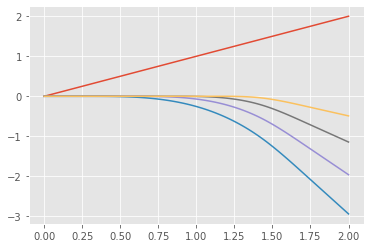

In [36]:
#X.shape
# natural_cubic_spline(X[['age']], knots=np.array([100, 120, 130, 140, 160, 200])).round(0)
ns = NS(n_knots=6, knots='quantile')
x = np.linspace(0,2,101)
plt.plot(x, ns.fit_transform(np.expand_dims(x, 1)))
plt.show()

In [45]:
# preprocessing.SplineTransformer.fit??

In [38]:
from scipy.interpolate import CubicSpline, BSpline, PPoly, splrep

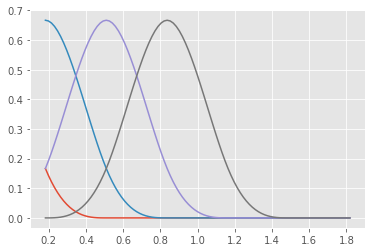

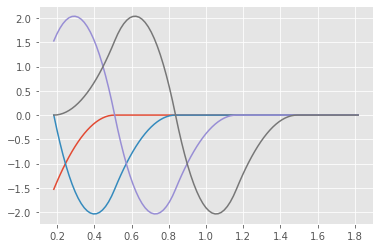

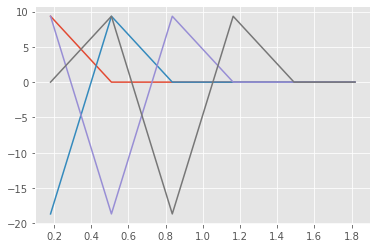

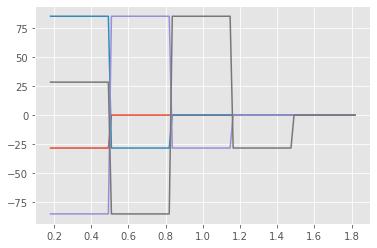

In [61]:
knots=np.linspace(-0.8,2.8,12)
bs=BSpline(knots, np.eye(len(knots)), k=3)
x = np.linspace(bs.t[3],bs.t[-4],101)
plt.plot(x,bs(x)[:,:4])
plt.show()
plt.plot(x,bs.derivative(1)(x)[:,:4])
plt.show()
plt.plot(x,bs.derivative(2)(x)[:,:4])
plt.show()
plt.plot(x,bs.derivative(3)(x)[:,:4])
plt.show()



In [ ]:
bs = BSpline(knots,np.eye

(3000, 1) (3000,)


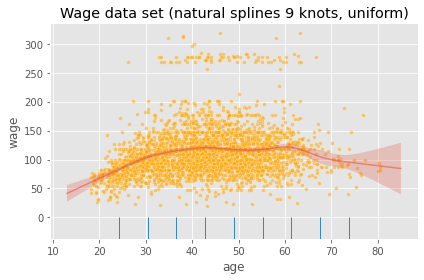

In [62]:
X = wage[['age']]
y = wage.wage

print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
x0_df = pd.DataFrame(dict(age=x0))

for d in range(9,10):
    model = make_pipeline(NS(n_knots=d, knots='uniform'),
                          preprocessing.StandardScaler(),
                          linear_model.LinearRegression()).fit(X,y)
    haty = model.predict(x0_df)
    sigma = sigma_haty(model, X, y, x0_df)
    plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, alpha=0.25)
    plt.plot(x0,haty, alpha=0.5) #, label=f'#cut points={d-1}')

#plt.legend()
kn = model[0].knots_
plt.plot(kn, np.zeros_like(kn)-20, '|', markersize=25)
plt.title(f'Wage data set (natural splines {d} knots, uniform)')
# plt.savefig('plots/11-26-nat-splines-wage.pdf')
plt.show()

(462, 1) (462,)


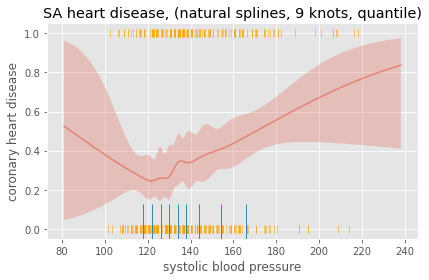

In [63]:
X, y = heart.data[['sbp']], heart.data.chd
print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.sbp+np.random.uniform(size=len(X.sbp)), 
                y=y, s=50, marker='|', color='orange')
x0 = np.linspace(X.sbp.min()-20, X.sbp.max()+20, 501)
x0_df = pd.DataFrame(dict(sbp=x0))


for d in range(9,10):
    model = make_pipeline(NS(n_knots=d, knots='quantile'),
                          preprocessing.StandardScaler(),
                          linear_model.LogisticRegression(penalty='none',
                                                        solver='newton-cg')).fit(X,y)
    haty = model.predict_proba(x0_df)[:,1]
    plt.fill_between(x0, *conf_int_logistic(model,X,y,x0_df), #haty-2*sigma,  haty+2*sigma, 
                     alpha=0.25)
    plt.plot(x0, haty, alpha=0.5) #, label=f'degree {d}')

#plt.legend()
kn = model[0].knots_ #bsplines_[0].t[3:-3]
plt.plot(kn, np.zeros_like(kn), '|', markersize=50)
plt.xlabel('systolic blood pressure')
plt.ylabel('coronary heart disease')
plt.title(f'SA heart disease, (natural splines, {d} knots, quantile)')
# plt.savefig('plots/11-26-nat-splines-sa-heart.pdf')
plt.show()

In [64]:
def h(x=1/7,a=0,b=1, scalex=True):
    if scalex:
        x = a+x*(b-a)
    def f(u):
        return -(1/(b-a)) *np.minimum((u-a)*(b-x),(b-u)*(x-a))
    return f

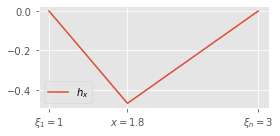

In [66]:
a,b = 1,3
u = np.linspace(a,b,501)
plt.figure(tight_layout=True, figsize=(4,2))
plt.plot(u,h(3/8,a=a,b=b)(u), label="$h_x$")
plt.xticks([1,1+6/8,3],['$\\xi_1=1$',f'$x={1+6/8:.2}$','$\\xi_n=3$'])
plt.legend()
# plt.savefig('plots/11-26-hx.pdf')


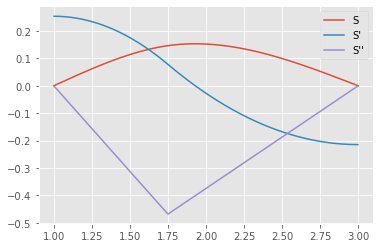

In [67]:
hx = h(3/8,a=a,b=b)(u)
hh = np.stack([h(v,a=a,b=b, scalex=False)(u) for v in u])
K = hh*hx

def mid(x, axis=None):
    if axis is not None:
        x= np.moveaxis(x,0,axis)
    x = (x[:-1]+x[1:])/2
    # print(x.shape)
    if axis is not None:
        x = np.moveaxis(x,0,axis)
        # print(x.shape)
    return x
def integrate(x, hx, axis=None):
    return x, (mid(hx,axis=axis)*np.diff(x)).sum(axis=axis)

u,S = integrate(u,K,axis=1)
plt.plot(u,S, label='S')
plt.plot(mid(u),np.diff(S)/np.diff(u), label="S'")

plt.plot(mid(mid(u)),np.diff(np.diff(S))/mid(np.diff(u))**2, label="S''")

plt.legend()


In [68]:
import csaps
import pygam

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,edu
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,3
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,2
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,3
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,1
...,...,...,...,...,...,...,...,...,...,...,...,...
376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293,2
302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464,1
10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408,0
14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033,2


defaultdict(list,
            {'deviance': [3678029.839808764, 3679020.8418304897],
             'diffs': [31.378732197353962, 2.766267034880968e-17]})

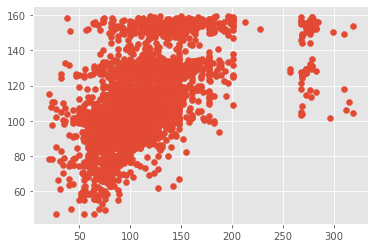

In [91]:
wage['edu']=preprocessing.LabelEncoder().fit_transform(wage.education)
wage
s,f = pygam.s, pygam.f
X = wage[['age','year','edu']]
gam = pygam.GAM(s(0)+s(1)+f(2)).fit(X, wage.wage)
plt.scatter(wage.wage, gam.predict(X))
# gam.logs_

(3000, 1) (3000,)


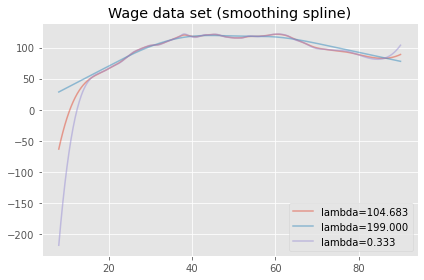

In [99]:
X = wage[['age']]
y = wage.wage

df = wage[['wage','age']].groupby('age').agg([lambda x: len(x),np.mean])
df.columns = ['weight','wage']

f = csaps.csaps(df.index, df.wage, weights=df.weight) #, normalizedsmooth=True)

print(X.shape,y.shape)
plt.figure(tight_layout=True)
x0 = np.linspace(X.age.min()-10, X.age.max()+10, 501)
x0_df = pd.DataFrame(dict(age=x0))

for p in [None, #0.1, 
          0.005, #0.5, 
          0.75]:
    f = csaps.csaps(df.index, df.wage, x0, weights=df.weight, smooth = p, normalizedsmooth=True)
    if p is None:
        p = f.smooth
        f = f.values
    plt.plot(x0, f ,#(x0), 
             alpha=0.5 , label=f'lambda={(1-p)/p:.3f}') #, label=f'#cut points={d-1}')

plt.legend()
plt.title(f'Wage data set (smoothing spline)')
# plt.savefig('plots/11-26-nat-splines-wage.pdf')
plt.show()

In [ ]:
X = wage[['age']]
y = wage.wage

df = wage[['wage','age']].groupby('age').agg([len,np.mean])
df.columns = ['weight','wage']
df['age']=df.index

knots = np.sort(df.index.values)
print(knots)
print(NS(knots=knots, include_bias=True).fit_transform(df[['age']]).shape)

print(Kmatrix(knots).shape)

sklearn.linear_model.Ridge.fit?

# #NS(knots=df.index
# plt.figure(tight_layout=True)
# #sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
# #sns.scatterplot(x=df.index, y=df.wage, size=df.weight, alpha=0.5, color='gray')
# x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
# x0_df = pd.DataFrame(dict(age=x0))

# for p in [0.1, 0.005, 0.5, 0.75, None]:
#     f = csaps.csaps(df.index, df.wage, x0, weights=df.weight, smooth = p, normalizedsmooth=True)

#     #sigma = sigma_haty(model, X, y, x0_df)
#     # plt.fill_between(x0, haty-2*sigma,  haty+2*sigma, alpha=0.25)
#     if p is None:
#         p = f.smooth
#         f = f.values
#     plt.plot(x0, f ,#(x0), 
#              alpha=0.5 , label=f'lambda={(1-p)/p:.3f}') #, label=f'#cut points={d-1}')

# plt.legend()
# # kn = model[0].knots_
# # plt.plot(kn, np.zeros_like(kn)-20, '|', markersize=25)
# plt.title(f'Wage data set (smoothing spline)')
# # plt.savefig('plots/11-26-nat-splines-wage.pdf')
# plt.show()

In [95]:
import statsmodels.api as sm

(3000, 1) (3000,)


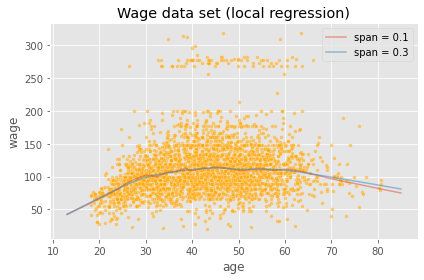

In [96]:
X = wage[['age']]
y = wage.wage

print(X.shape,y.shape)
plt.figure(tight_layout=True)
sns.scatterplot(x=X.age+np.random.uniform(size=len(X.age)), y=y, s=15, alpha=0.5, color='orange')
x0 = np.linspace(X.age.min()-5, X.age.max()+5, 501)
x0_df = pd.DataFrame(dict(age=x0))

for s in [0.1,0.3]: #range(9,10):
    haty= sm.nonparametric.lowess(y,X.age,frac=s,xvals=x0)
    plt.plot(x0,haty, alpha=0.5, label=f'span = {s}')

plt.legend()
plt.title(f'Wage data set (local regression)')
# plt.savefig('plots/11-26-loess-wage.pdf')
plt.show()

In [100]:
heart

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

To read into R:
read.table("http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data",
	sep=",",head=T,row.names=1)

           sbp  tobacco    ldl  adiposity  famhist  typea  obesity  alcohol  \
row.names   

In [103]:
heart.data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [101]:
from sklearn.model_selection import train_test_split

In [119]:
formula = "chd ~ " + " + ".join([f"cr({x},5)" for x in heart.data.columns if x not in ['chd','famhist']])
formula += ' + famhist'
formula
heart.data.columns

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd', 'famhist_'],
      dtype='object')

In [123]:
s,f = pygam.s, pygam.f
heart.data['famhist_'] = preprocessing.LabelBinarizer().fit_transform(heart.data.famhist)
train_test_split(heart.data,test_size=0.2,shuffle=True,random_state=1)
X=heart.data.drop(columns=['chd','famhist'])
y=heart.data.chd
heart_gam = pygam.LogisticGAM().fit(X,y)

#heart_gam.summary()

In [124]:
heart_gam.accuracy(X,y)

0.7792207792207793

In [ ]:
import scipy

[[0.17 0.67 0.17 0.   0.   0.   0.   0.   0.  ]
 [0.   0.17 0.67 0.17 0.   0.   0.   0.   0.  ]
 [0.   0.   0.17 0.67 0.17 0.   0.   0.   0.  ]
 [0.   0.   0.   0.17 0.67 0.17 0.   0.   0.  ]
 [0.   0.   0.   0.   0.17 0.67 0.17 0.   0.  ]
 [0.   0.   0.   0.   0.   0.17 0.67 0.17 0.  ]
 [0.   0.   0.   0.   0.   0.   0.17 0.67 0.17]]
(7, 9)


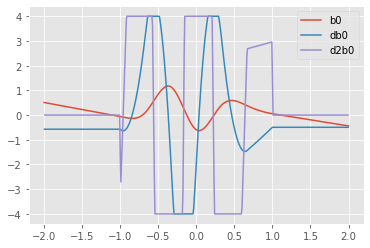

In [97]:
X = np.random.normal(size=(20,1))
X0 = np.linspace(-1,1,7).reshape(-1,1)
X0.sort(axis=0)
spline = preprocessing.SplineTransformer(knots=X0,
                                         degree=3,
                                         extrapolation='linear', 
                                         include_bias=True).fit(X0)

print(spline.transform(X0).round(2))
print(spline.transform(X0).shape)

x=np.linspace(-2,2,501)

for i in range(1):
    beta = np.zeros(spline.n_features_out_-4)
    beta[i] = 1
    beta = np.random.normal(size=beta.shape)
    y = spline.transform(x.reshape(-1,1))[:,2:-2] @ beta
    plt.plot(x,y, label=f'b{i}')
    
    xc = 0.5*(x[:-1]+x[1:])
    yc = np.diff(y)/np.diff(x)
    plt.plot(xc,yc.clip(-4,4),label=f'db{i}')
    
    yc = np.diff(yc)/np.diff(xc)
    xc = 0.5*(xc[:-1]+xc[1:])
    plt.plot(xc,yc.clip(-4,4),label=f'd2b{i}')
    
    yc = np.diff(yc)/np.diff(xc)
    xc = 0.5*(xc[:-1]+xc[1:])
    #plt.plot(xc,yc.clip(-4,4),label=f'd3b{i}')
    
plt.legend()
plt.show()
#print(spline.transform(x.reshape(-1,1)).round(2))


In [ ]:
    
smarket = ISLRdata('Smarket')
print(smarket.title, smarket.package)
print(smarket.__doc__)


In [ ]:
spam = load_ESL_dataset('spam')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
spam.data

In [ ]:
def smoothing_penalty_matrix(x):
    delta = np.diff(x)
    Delta = np.diag(-1/delta,1)
    Delta[:,:-1] -=  Delta[:,1:]
    Delta[:-1] -= Delta[1:]
    Delta = Delta[:-2]
    W = np.diag(delta[1:-1]/6,1)+np.diag((delta[:-1]+delta[1:])/3)+np.diag(delta[1:-1]/6,-1)
    return np.dot(Delta.T,np.linalg.solve(W, Delta))

def modified_smoothing_penalty_matrix(x):
    return smoothing_penalty_matrix(x)[1:-1,1:-1]

def smooth(x, y, weights=1):
    x, y = np.asarray(x), np.asarray(y)
    w = np.asarray(weights)
    order = np.argsort(x)
    x,y = x[order], y[order]
    P = modified_smoothing_penalty_matrix(x)
    L = np.linalg.cholesky(P)
    X = np.linalg.inv(L.T)
    print(X.shape)
    X = np.concatenate([np.zeros((1,X.shape[1])),
                        X,
                        np.zeros((1,X.shape[1]))],axis=0)
    print(X.shape)
    x0 = x
    x0 = (x0-(w*x0).sum()/w.sum())
    s = (w*(x0**2)).sum()**0.5
    x0 /= s
    X -= np.outer(x0, np.dot(X.T, w*x0))
    # dy = (y[-1]-y[0])*(x-x[0])/(x[-1]-x[0]) #
    dy = np.dot(y,w*x0)*x0
    dy -= (w*dy).sum()/w.sum()
    y0 = y - dy 
    return X, y0, dy

In [ ]:
df['age']=df.index

X, y, dy = smooth(df.age,df.wage, df.weight)
ridge = make_pipeline(# preprocessing.StandardScaler(),
                      sklearn.linear_model.RidgeCV(alphas=[1,5,10,15,100,1000]))
ridge.fit(X,y, ridgecv__sample_weight=df.weight)
plt.plot(y+dy)
plt.plot(ridge.predict(X)+dy)

In [ ]:
X, y, dy = smooth(-df.age,df.wage, df.weight)
ridge = make_pipeline(# preprocessing.StandardScaler(),
                      sklearn.linear_model.RidgeCV(alphas=[1,5,10,15,100,1000]))
ridge.fit(X,y, ridgecv__sample_weight=df.weight)
plt.plot(y+dy)
plt.plot(ridge.predict(X)+dy)

In [ ]:
import csaps

In [ ]:
df = wage[['wage','age']].groupby('age').agg([len,np.mean])
df.columns = ['weight','wage']
f = csaps.csaps(df.index, df.wage, weights=df.weight,normalizedsmooth=True)

In [ ]:
import statsmodels.api as sm

smGAM = sm.OLS.from_formula('wage ~ cr(year,df=5) + cr(age,df=4) + education', data=wage).fit()
smGAM.summary()


In [ ]:
smGAM1 = sm.OLS.from_formula('wage ~ year + age + education', data=wage).fit()
smGAM1.summary()


In [ ]:
smGLM = sm.GLM.from_formula('chd ~ cr(sbp,df=5) + cr(age,df=4)', 
                            data=heart, 
                            family=sm.families.Binomial()).fit()

In [129]:
mpg=ISLRdata('Auto').mpg

In [133]:
(mpg>mpg.median())[:300].mean()

0.36333333333333334

In [134]:
sm.GLM.predict?

Signature:
sm.GLM.predict(
    self,
    params,
    exog=None,
    exposure=None,
    offset=None,
    linear=False,
)
Docstring:
Return predicted values for a design matrix

Parameters
----------
params : array_like
    Parameters / coefficients of a GLM.
exog : array_like, optional
    Design / exogenous data. Is exog is None, model exog is used.
exposure : array_like, optional
    Exposure time values, only can be used with the log link
    function.  See notes for details.
offset : array_like, optional
    Offset values.  See notes for details.
linear : bool
    If True, returns the linear predicted values.  If False,
    returns the value of the inverse of the model's link function at
    the linear predicted values.

Returns
-------
An array of fitted values

Notes
-----
Any `exposure` and `offset` provided here take precedence over
the `exposure` and `offset` used in the model fit.  If `exog`
is passed as an argument here, then any `exposure` and
`offset` values in the fit will